In [1]:
import tensorflow as tf
import os
import random
import numpy as np

In [2]:
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import color
import matplotlib.pyplot as plt

In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [4]:
TRAIN_PATH = 'imSeg/train/'
TEST_PATH = 'imSeg/test/'
VALIDATION_PATH = 'imSeg/validation/'

train_ids = os.listdir(TRAIN_PATH + 'images/')
test_ids = os.listdir(TEST_PATH + 'images/')
validation_ids = os.listdir(VALIDATION_PATH + 'images/')

In [5]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

X_val = np.zeros((len(validation_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_val = np.zeros((len(validation_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [7]:
#### Train Image ######

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    img = imread(TRAIN_PATH + 'images/' + id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_ = imread(TRAIN_PATH + 'labels/' + id_)
    mask_ = color.rgb2gray(mask_)
    mask_ = mask_.reshape((512,512,1))
    mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = np.maximum(mask, mask_)          
    Y_train[n] = mask

100%|██████████| 810/810 [00:39<00:00, 20.33it/s]


In [8]:
########### Validation Images ###########

for n, id_ in tqdm(enumerate(validation_ids), total=len(validation_ids)):   
    img = imread(VALIDATION_PATH + 'images/' + id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_val[n] = img  
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_ = imread(VALIDATION_PATH + 'labels/' + id_)
    mask_ = color.rgb2gray(mask_)
    mask_ = mask_.reshape((512,512,1))
    mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = np.maximum(mask, mask_)          
    Y_val[n] = mask

100%|██████████| 200/200 [00:09<00:00, 20.89it/s]


In [9]:
########### Test Images ###########

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):   
    img = imread(TEST_PATH + 'images/' + id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

100%|██████████| 200/200 [00:06<00:00, 28.92it/s]


In [10]:

#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [11]:
################################
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train,validation_data=(X_val,Y_val), batch_size=16, epochs=25, callbacks=callbacks)

####################################

Epoch 1/25
51/51 [==============================] - 14s 170ms/step - loss: 0.2564 - accuracy: 0.9153 - val_loss: 0.0870 - val_accuracy: 0.9798- loss: 0.4071 - accuracy: 0. - ETA: 3s - loss: 0.3
Epoch 2/25
51/51 [==============================] - 5s 103ms/step - loss: 0.0757 - accuracy: 0.9777 - val_loss: 0.0766 - val_accuracy: 0.97983 - accu - ETA: 1s - loss: 0.0774 - accuracy: 0.97 - ETA: 0s - loss: 0.0
Epoch 3/25
51/51 [==============================] - 5s 103ms/step - loss: 0.0638 - accuracy: 0.9791 - val_loss: 0.0706 - val_accuracy: 0.97988 
Epoch 4/25
51/51 [==============================] - 5s 104ms/step - loss: 0.0639 - accuracy: 0.9784 - val_loss: 0.0768 - val_accuracy: 0.9798
Epoch 5/25
51/51 [==============================] - 5s 103ms/step - loss: 0.0588 - accuracy: 0.9797 - val_loss: 0.0531 - val_accuracy: 0.9832 loss: 0.0589 - accuracy
Epoch 6/25
51/51 [==============================] - 5s 104ms/step - loss: 0.0542 - accuracy: 0.9816 - val_loss: 0.0525 - val_accuracy: 0.983

In [12]:
preds_test = model.predict(X_test, verbose=1)

7/7 [==============================] - 2s 39ms/step


In [27]:
preds_test_t = (preds_test > 0.5).astype(np.uint8)

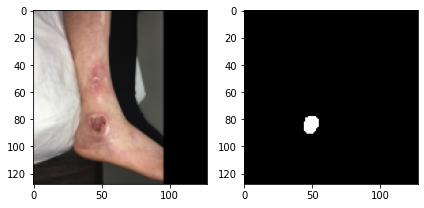

In [30]:
plt.subplot(1,2,1)
plt.imshow(X_test[0])
plt.subplot(1,2,2)
plt.imshow(preds_test_t[0],cmap='gray')
plt.tight_layout()

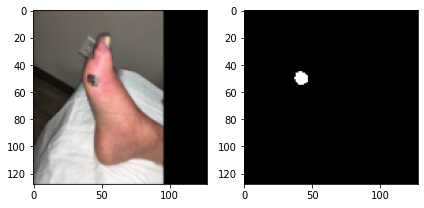

In [31]:
plt.subplot(1,2,1)
plt.imshow(X_test[11])
plt.subplot(1,2,2)
plt.imshow(preds_test_t[11],cmap='gray')
plt.tight_layout()

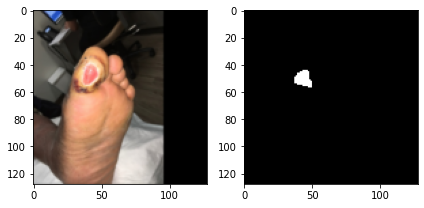

In [32]:
plt.subplot(1,2,1)
plt.imshow(X_test[150])
plt.subplot(1,2,2)
plt.imshow(preds_test_t[150],cmap='gray')
plt.tight_layout()

In [34]:
model.save_weights('./checkpoints/my_checkpoint')

In [35]:
model.save('unet_model.h5')